<>:121: SyntaxWarning: invalid escape sequence '\D'
<>:121: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Matilde\AppData\Local\Temp\ipykernel_1900\2875584882.py:121: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel(f'$\Delta$E')


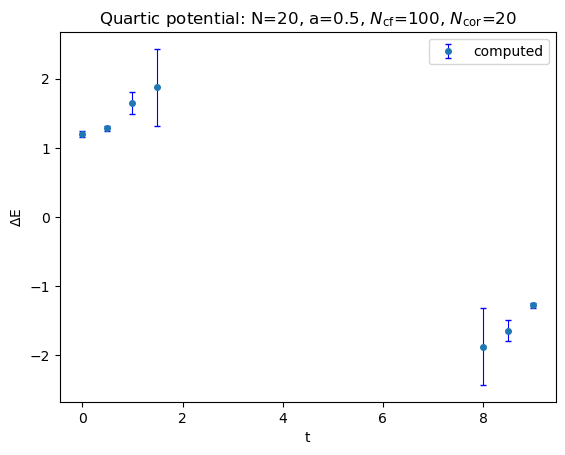

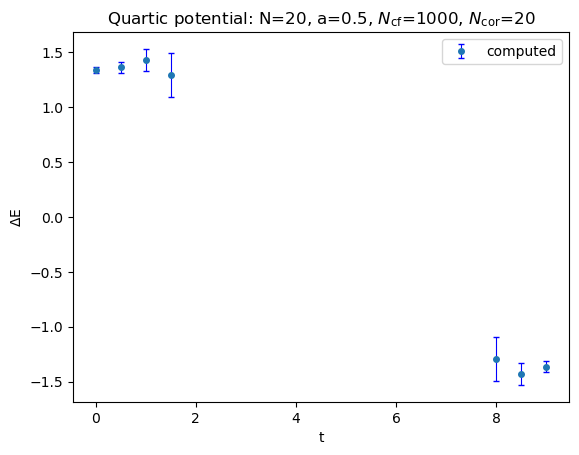

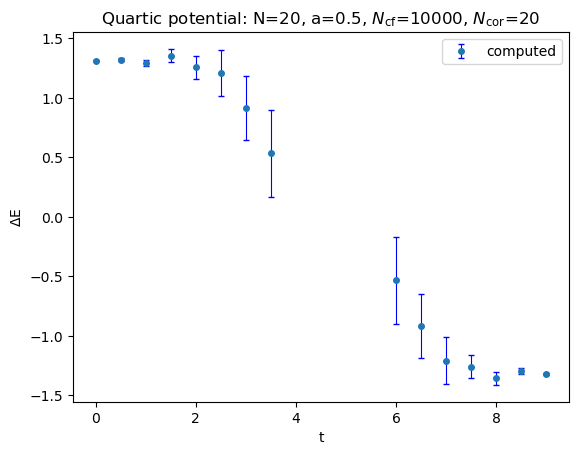

In [2]:
#Quartic potential case - evaluation of deltaE = E_1 - E_0 - binned and bootstrapped datas (reliable errors)
import vegas
from tqdm.notebook import tqdm
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

cor_power=1 #if correlator x(t)x(t+a) it's 1, if correlator x(t)**3x(t+a)**3 it's 3

eps=1.4
N=20
N_cor=20
N_cfv=[100,1000,10000]
a=0.5
binsize=20

#function which updates each site of an initial path in order to get a new one (Metropolis algorithm)
@njit
def update(x):
    for j in range(N):
        #saving original value and compute the action 
        old_x = x[j]           
        old_Sj = S(j,x)
        #update the x[j] using a uniformly distributed probability 
        x[j] += np.random.uniform(-eps,eps)     
        #compute the difference between the old and new action
        dS = S(j,x) - old_Sj 
        if dS>0 and np.exp(-dS)<np.random.uniform(0,1): #condition to restore the old value
            x[j] = old_x 

@njit
def S(j,x): #action
    #next and previous site by taking into account the periodicity xN=x0
    jp = (j+1)%len(x)
    jm = (j-1)%len(x) 
    return a*V(x[j]) +x[j]*(x[j]-x[jp]-x[jm])/a

@njit
def V(x): #potential
    return (x**4)/2

@njit
def compute_G(x,n): #computes G(t) for a given path x and a fixed n
    g = 0
    for j in range(0,N):
        g += (x[j]**cor_power)*(x[(j+n)%N]**cor_power)
    return g/N

@njit #thermalize and erase correlations
def MCaverage(x,G):
    for j in range(0,len(x)): 
        x[j] = 0 #initialization of the path as all zeros
    for j in range(10*N_cor): #thermalization since the path with all zero is atypical
        update(x)
    for alpha in range(len(G)): #Number of random path the Metropolis algorithm is generating
        for j in range(N_cor): #erasing correlations
            update(x)
        for n in range(0,N):
            G[alpha][n] = compute_G(x,n) #filling the G with the computed G(t) of the path x(alpha) with n from 0 to N
    return G

@njit
def bootstrap_deltaE(G,nbstrap=100): # Delta E + errors
    bootstrap_E = np.zeros((nbstrap,N-1))
    for i in range(nbstrap): # bs copies of deltaE
        g = bootstrap(G)
        g_avg=average(g)
        bootstrap_E[i]=deltaE(g_avg)
    sdevE = stdDev(bootstrap_E) # spread of deltaE’s
    avgE=average(bootstrap_E)
    return avgE,sdevE

def bin(G,binsize): #binning the G's
    G_binned = np.zeros((int(len(G)/binsize), N)) #matrix G binned in alphas
    k=0
    for i in range(0,len(G),binsize): #binning the G
        G_avg = 0
        for j in range(binsize): #summing for each bin
            G_avg = G_avg + G[i+j]
        G_binned[k]=(G_avg/binsize) #bin average
        k+=1
    return G_binned

@njit
def stdDev(G):
    sdev = np.abs(average(G**2)-average(G)**2)**0.5
    return sdev

@njit
def average(G):
    sum = np.sum(G, axis=0)
    avg_G = sum/len(G)
    return avg_G

@njit
def deltaE(G): #compute the deltaE
    delta_E=np.zeros(len(G)-1)
    for j in range(len(G)-1):
        delta_E[j]=np.log(G[j]/G[j+1])
    return delta_E/a

@njit
def bootstrap(G): #bootstrapping the G's
    G_bootstrap = np.zeros((len(G), N)) # new ensemble
    for i in range(len(G)):
        k = int(np.random.uniform(0,len(G))) # choose random config
        G_bootstrap[i]=G[k] # keep G[alpha]
    return G_bootstrap

if __name__ == "__main__":
    for N_cf in N_cfv:
        G=np.zeros((N_cf, N))
        x=np.zeros(N)
        G_comp=MCaverage(x,G) #G_comp matrix
        G_binned=bin(G_comp,binsize) #matrix with alphas binned
        avgE,sdevE=bootstrap_deltaE(G_binned,nbstrap=100)
    
        t = [a*q for q in range(N-1)]
        plt.errorbar(t, avgE, yerr=sdevE, fmt="o",label='computed',ecolor="blue",elinewidth=0.8,capsize=2, markersize=4)
        plt.xlabel('t')
        plt.ylabel(f'$\Delta$E')
        plt.title(f'Quartic potential: N={N}, a={a}, ' + r'$N_{\text{cf}}$='+f'{N_cf}, '+ r'$N_{\text{cor}}$='+f'{N_cor}')
        plt.legend()
        #plt.axis([-0.2, 3.2, 0, 3])
        #plt.savefig(f'QuarPot3_{N_cf}.png')
        plt.show()